In [ ]:
import os
import zipfile
import urllib.request

def download_and_extract_zip(url, dest_folder="dataset"):
    zip_filename = url.split("/")[-1]

    zip_path = os.path.join(os.getcwd(), zip_filename)

    print(f"Baixando o arquivo de {url}...")
    urllib.request.urlretrieve(url, zip_path)
    print(f"Arquivo baixado para {zip_path}")

    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
        print(f"Pasta '{dest_folder}' criada.")

    print(f"Extraindo o arquivo principal para a pasta '{dest_folder}'...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)
    print(f"Arquivo principal extraído com sucesso!")

    os.remove(zip_path)
    print(f"Arquivo ZIP principal removido após extração.")

    nested_zip_path = os.path.join(dest_folder, 'UCI HAR Dataset.zip')

    if os.path.exists(nested_zip_path):
        print(f"Arquivo ZIP encontrado dentro da pasta '{dest_folder}': {nested_zip_path}")
        
        print(f"Extraindo o arquivo ZIP dentro da pasta '{dest_folder}'...")
        with zipfile.ZipFile(nested_zip_path, 'r') as nested_zip_ref:
            nested_zip_ref.extractall(dest_folder)
        print(f"Arquivo extraído com sucesso!")

        os.remove(nested_zip_path)
        print(f"Arquivo ZIP interno removido após extração.")
    else:
        print(f"Nenhum arquivo 'UCI HAR Dataset.zip' encontrado dentro de '{dest_folder}'.")


url = "https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip"
download_and_extract_zip(url)

Baixando o arquivo de https://archive.ics.uci.edu/static/public/240/human+activity+recognition+using+smartphones.zip...
Arquivo baixado para /home/dramaturgie/projects/restic/human+activity+recognition+using+smartphones.zip
Extraindo o arquivo principal para a pasta 'dataset'...
Arquivo principal extraído com sucesso!
Arquivo ZIP principal removido após extração.
Arquivo ZIP encontrado dentro da pasta 'dataset': dataset/UCI HAR Dataset.zip
Extraindo o arquivo ZIP dentro da pasta 'dataset'...
Arquivo extraído com sucesso!
Arquivo ZIP interno removido após extração.


In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

### dataset/UCI HAR Dataset.names

O dataset contém 561 features por amostra, extraídas de dados de aceleração e giroscópio.
Cada amostra possui um rótulo de atividade associado.
Os dados já estão divididos em train e test.

In [30]:
# Carregar as features
features = pd.read_csv('dataset/UCI HAR Dataset/UCI HAR Dataset/features.txt', sep=r'\s+', header=None)

# Carregar os dados de treinamento
X_train = pd.read_csv('dataset/UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', sep=r'\s+', header=None)
y_train = pd.read_csv('dataset/UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', sep=r'\s+', header=None)

# Carregar os dados de teste
X_test = pd.read_csv('dataset/UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt', sep=r'\s+', header=None)
y_test = pd.read_csv('dataset/UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', sep=r'\s+', header=None)

Escale os dados para normalizar as magnitudes:

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Reduzindo a dimensionalidade usando PCA (para facilitar a visualização)

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduza para 2 dimensões
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

/tmp/ipykernel_50603/2822337161.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s=5, alpha=0.7, cmap='viridis')


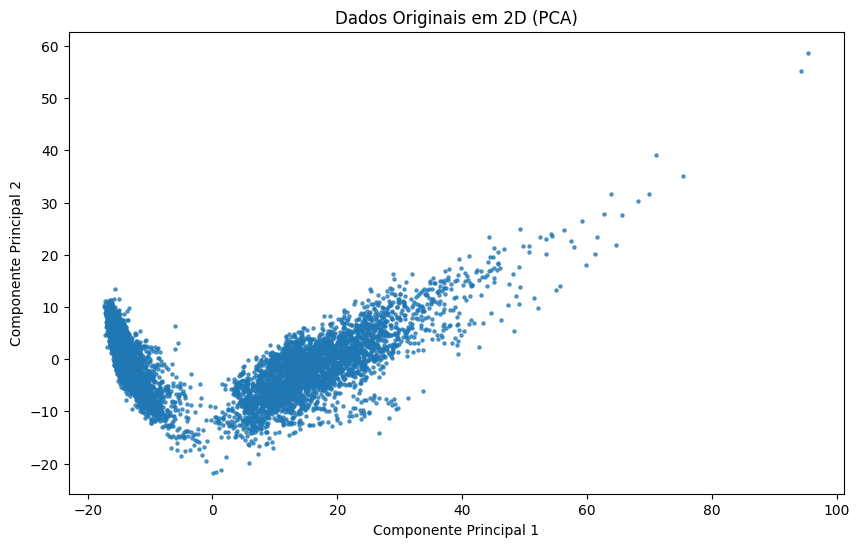

In [33]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], s=5, alpha=0.7, cmap='viridis')
plt.title('Dados Originais em 2D (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

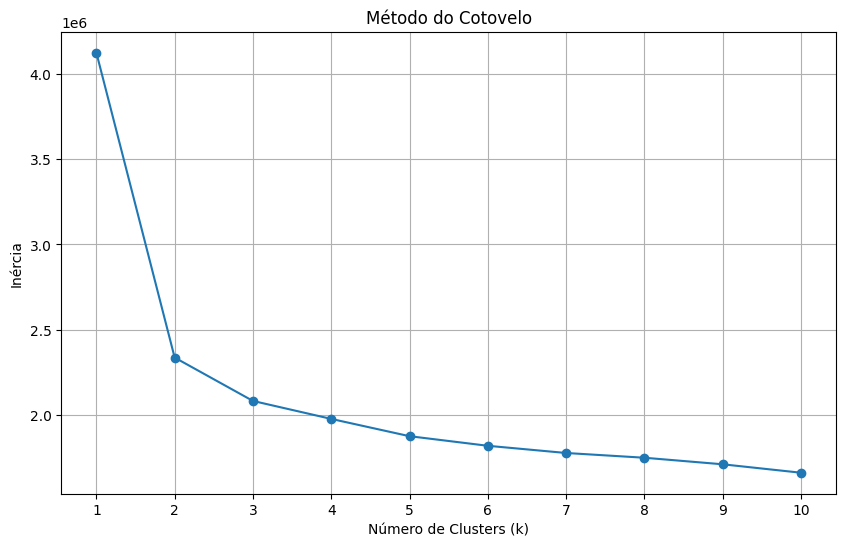

In [34]:
inertia = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_values, inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inércia')
plt.xticks(k_values)
plt.grid()
plt.show()


Escolhendo o número de clusters (6 para as 6 atividades):

In [35]:
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(X_train_scaled)

KMeans(n_clusters=6, random_state=42)

In [36]:
clusters = kmeans.predict(X_train_scaled)

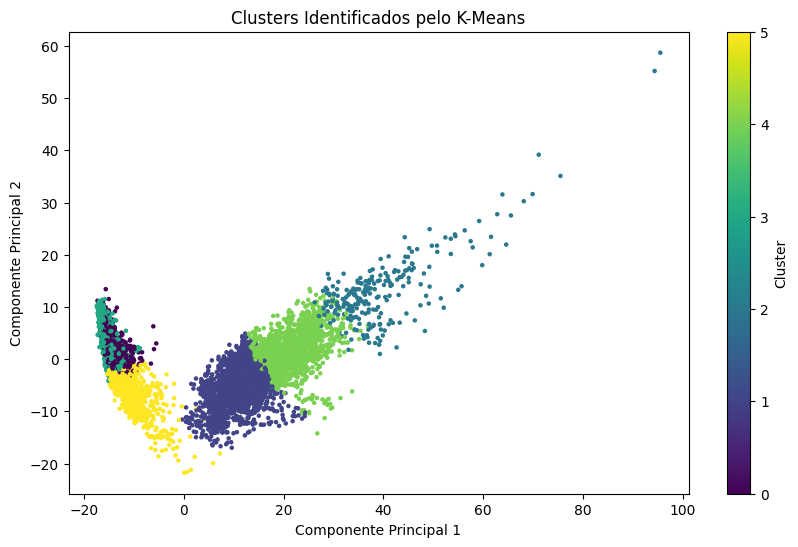

In [37]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', s=5)
plt.title('Clusters Identificados pelo K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()


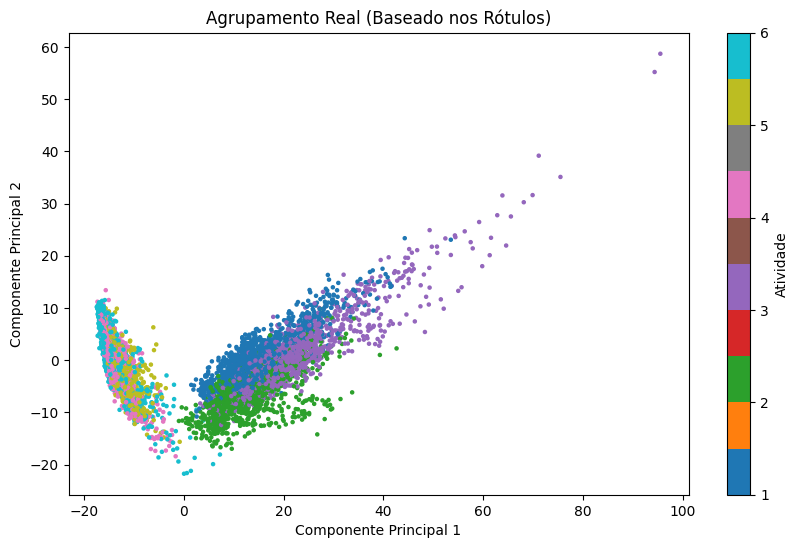

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train.values.ravel(), cmap='tab10', s=5)
plt.title('Agrupamento Real (Baseado nos Rótulos)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Atividade')
plt.show()


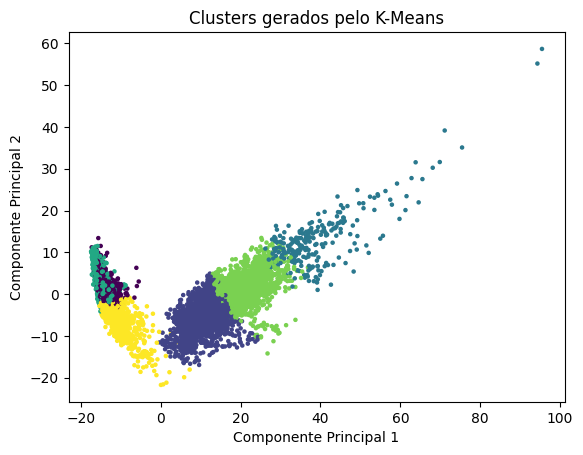

In [39]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', s=5)
plt.title('Clusters gerados pelo K-Means')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.show()

Initialization complete
Iteration 0, inertia 3003350.9884389094.
Iteration 1, inertia 1929633.3878048228.
Iteration 2, inertia 1896017.0796390632.
Iteration 3, inertia 1890702.4989632021.
Iteration 4, inertia 1888115.9183286938.
Iteration 5, inertia 1885619.969692599.
Iteration 6, inertia 1881424.7293776786.
Iteration 7, inertia 1877895.6965655563.
Iteration 8, inertia 1874454.500753358.
Iteration 9, inertia 1871324.985403029.
Iteration 10, inertia 1866767.8340862.
Iteration 11, inertia 1859402.9414766966.
Iteration 12, inertia 1849028.0171811988.
Iteration 13, inertia 1841501.746575405.
Iteration 14, inertia 1835451.9043344192.
Iteration 15, inertia 1830887.1503676353.
Iteration 16, inertia 1827768.4350569774.
Iteration 17, inertia 1825556.5705726836.
Iteration 18, inertia 1823457.8194892271.
Iteration 19, inertia 1822076.153279592.
Iteration 20, inertia 1821038.8580184511.
Iteration 21, inertia 1820291.237647408.
Iteration 22, inertia 1819930.4501658368.
Iteration 23, inertia 1819608

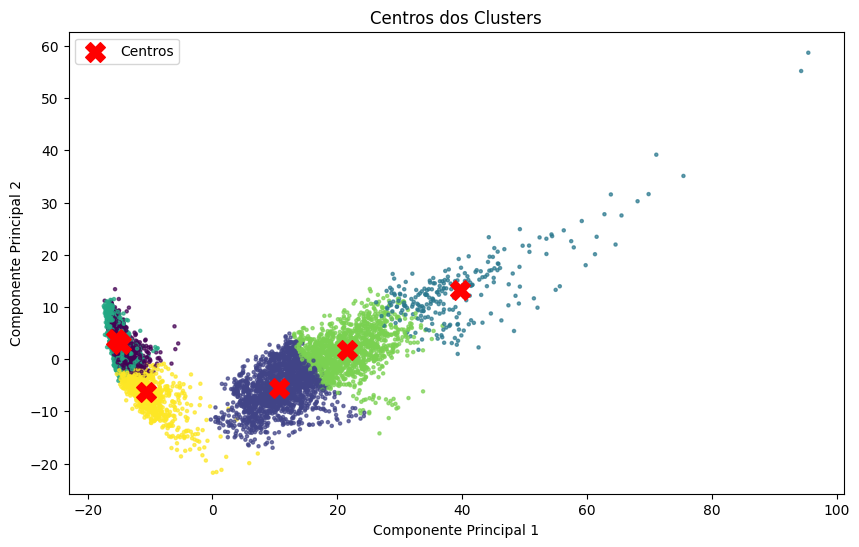

In [40]:
kmeans = KMeans(n_clusters=6, random_state=42, max_iter=300, n_init=10, verbose=1)
kmeans.fit(X_train_scaled)

centers = kmeans.cluster_centers_
if X_train_scaled.shape[1] > 2:
    centers_pca = pca.transform(centers)
else:
    centers_pca = centers

plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=clusters, cmap='viridis', s=5, alpha=0.7)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='X', s=200, label='Centros')
plt.title('Centros dos Clusters')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()


In [41]:
from sklearn.metrics import adjusted_rand_score

ari = adjusted_rand_score(y_train.values.ravel(), clusters)
print(f'Adjusted Rand Index: {ari}')

Adjusted Rand Index: 0.41971368603551157


In [42]:
from sklearn.metrics import silhouette_score

score = silhouette_score(X_train_scaled, clusters)
print(f'Silhouette Score: {score}')

Silhouette Score: 0.1086410631864108
